(f_rs_band_math)=

---------------
```{admonition} Learning Objectives
  - Learn about basic principals of band math
  - Calculate common indicies like NDVI, EVI etc
```
```{admonition} Review
* [Raster Data ](c_rasters.md)
* [Opening Remotely Sensed Data](f_rs_io.md)
* [Sensor specific configurations](f_rs_config.md)
```
--------------


# Band math

## Vegetation indices
Healthy vegetation (with chlorophyll) reflects more near-infrared (NIR) and green light compared to other wavelengths and absorbs more red and blue light. We can use this effect to generate a number of vegetation indices including the following:


### Enhanced Vegetation Index (EVI)
EVI is an index of vegetation that is optimized to improve sensitivity to high biomass and better handling of background and atmospheric influences. It is calculated with the formula below using the Near Infrared (NIR), Red and Blue bands. There are also a number of parameters like $C_{1}$ that are specific to each sensor. Luckily geowombat handles this all for you! 

$$EVI = G\times \frac{NIR-Red}{NIR+C_{1}\times Red-C_{2}\times Blue+L}$$

The result of this formula generates a value between -1 and +1.  Low reflectance (low values) in the red channel and high reflectance in the NIR channel will yield a high EVI value.

In [1]:
import geowombat as gw
from geowombat.data import rgbn
import matplotlib.pyplot as plt


Calculate a vegetation index, returning an `Xarray.DataArray`.

In [2]:
with gw.open(rgbn) as ds:
    print(ds)
    evi = ds.gw.evi(sensor='rgbn', scale_factor=0.0001)
    print(evi)

<xarray.DataArray (band: 4, y: 403, x: 515)>
dask.array<open_rasterio-7d79b842e18ff1b96035367084e2d858<this-array>, shape=(4, 403, 515), dtype=uint8, chunksize=(1, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 2.05e+06 2.05e+06 2.05e+06 ... 2.048e+06 2.048e+06
  * x        (x) float64 7.93e+05 7.93e+05 7.93e+05 ... 7.956e+05 7.956e+05
Attributes: (12/13)
    transform:          (5.0, 0.0, 792988.0, 0.0, -5.0, 2050382.0)
    crs:                +init=epsg:32618
    res:                (5.0, 5.0)
    is_tiled:           1
    nodatavals:         (nan, nan, nan, nan)
    scales:             (1.0, 1.0, 1.0, 1.0)
    ...                 ...
    AREA_OR_POINT:      Area
    DataType:           Generic
    filename:           /home/mmann1123/anaconda3/envs/pygisbookgw/lib/python...
    resampling:         nearest
    data_are_separate:  0
    data_are_stacked:   0
<xarray.DataArray (band: 1, y: 403, x: 515)>
dask.array<broadcast_to, 

Or use the configuration context to set parameters.

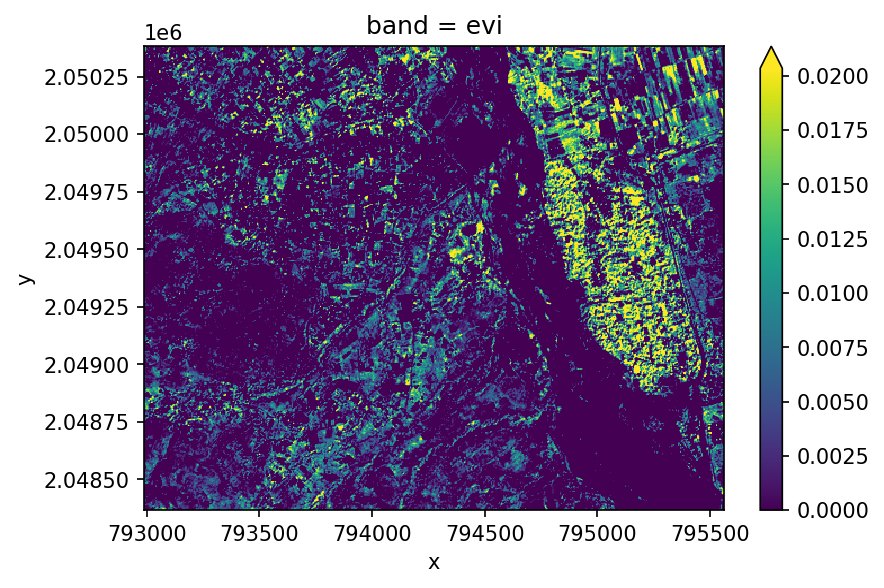

In [3]:
fig, ax = plt.subplots(dpi=150)

with gw.config.update(sensor='rgbn', scale_factor=0.0001):
    with gw.open(rgbn) as ds:
        evi = ds.gw.evi()
        evi.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

### Two-band Enhanced Vegetation Index (EVI2)
We can also calcuate an approximation of EVI with two bands using $G\times ((NIR-RED)/(L+NIR+C\times Red))$

This allows us to extend EVI calculations back in time using AVHRR, and avoids some problems with the blue band which tends to be noisy.

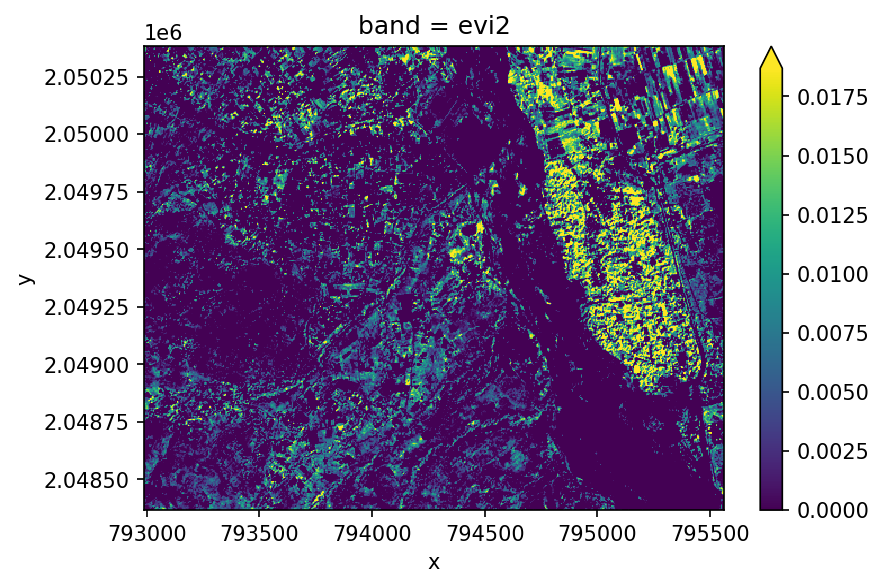

In [4]:
fig, ax = plt.subplots(dpi=150)

with gw.config.update(sensor='rgbn', scale_factor=0.0001):
    with gw.open(rgbn) as ds:
        evi2 = ds.gw.evi2()
        evi2.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

### Normalized Difference Indices (NDVI)
The simplest vegetation metric is NDVI, which is just the normalized difference between the Red and NIR bands. It is calculated as follows $\frac{NIR-Red}{NIR+Red}$.

We can calculate it using the generic `norm_diff` function for any two-band combination.

In [5]:
with gw.config.update(sensor='rgbn'):
    with gw.open(rgbn) as ds:
        d = ds.gw.norm_diff('red', 'nir')
        print(d)

<xarray.DataArray (band: 1, y: 403, x: 515)>
dask.array<broadcast_to, shape=(1, 403, 515), dtype=float64, chunksize=(1, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 2.05e+06 2.05e+06 2.05e+06 ... 2.048e+06 2.048e+06
  * x        (x) float64 7.93e+05 7.93e+05 7.93e+05 ... 7.956e+05 7.956e+05
  * band     (band) <U9 'norm-diff'
Attributes: (12/17)
    transform:          (5.0, 0.0, 792988.0, 0.0, -5.0, 2050382.0)
    crs:                +init=epsg:32618
    res:                (5.0, 5.0)
    is_tiled:           1
    nodatavals:         (None,)
    scales:             (1.0,)
    ...                 ...
    resampling:         nearest
    data_are_separate:  0
    data_are_stacked:   0
    pre-scaling:        1.0
    vi:                 norm-diff
    drange:             (-1, 1)


### Tasseled Cap Transformations
Tasseled cap tranform uses a linear equation to try to differentiate different components of the spectrum that are of interest for vegetation dynamics such as phenological stages. The output includes three bands including `brightness`, `greeness` for vegetation, and `wetness` as an idicator of soil and canopy moisture. Use `.sel(band='wetness')` to select them individually.

In [6]:
with gw.config.update(sensor='qb', scale_factor=0.0001):
    with gw.open(rgbn) as ds:
        tcap = ds.gw.tasseled_cap()
        print(tcap) 

<xarray.DataArray (band: 3, y: 403, x: 515)>
dask.array<transpose, shape=(3, 403, 515), dtype=object, chunksize=(3, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 2.05e+06 2.05e+06 2.05e+06 ... 2.048e+06 2.048e+06
  * x        (x) float64 7.93e+05 7.93e+05 7.93e+05 ... 7.956e+05 7.956e+05
  * band     (band) <U10 'brightness' 'greenness' 'wetness'
Attributes: (12/14)
    transform:          (5.0, 0.0, 792988.0, 0.0, -5.0, 2050382.0)
    crs:                +init=epsg:32618
    res:                (5.0, 5.0)
    is_tiled:           1
    nodatavals:         (nan, nan, nan, nan)
    scales:             (1.0, 1.0, 1.0, 1.0)
    ...                 ...
    DataType:           Generic
    sensor:             Quickbird with 4 (visible + NIR) bands
    filename:           /home/mmann1123/anaconda3/envs/pygisbookgw/lib/python...
    resampling:         nearest
    data_are_separate:  0
    data_are_stacked:   0


Sources: 
- [Wikipedia EVI](https://en.wikipedia.org/wiki/Enhanced_vegetation_index)
- [Wikipedia Tasseled Cap](https://en.wikipedia.org/wiki/Tasseled_cap_transformation)